In [1]:
# Import our dependencies.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf
# Import the kerastuner library
import keras_tuner as kt


In [2]:
#  Import and read the datasets.csv
import pandas as pd 
crime_df = pd.read_csv("../cleaned_data_2015_2018/all_data_merged_cleaned_2015_2018.csv")
crime_df.head()

,CRIME,OCC_YEAR,OCC_MONTH,OCC_DAY,OCC_DOW,OCC_HOUR,PREMISES_TYPE,HOOD_140,NEIGHBOURHOOD_140,LONG_WGS84,LAT_WGS84,OCC_DATETIME
0,assault,2015,January,1,Thursday,23,House,115,Mount Dennis (115),-79.504668,43.693238,2015-01-01 23:00:00
1,assault,2015,January,1,Thursday,3,Commercial,77,Waterfront Communities-The Island (77),-79.392855,43.647315,2015-01-01 03:00:00
2,assault,2015,January,1,Thursday,2,Commercial,77,Waterfront Communities-The Island (77),-79.387700,43.649776,2015-01-01 02:00:00
3,assault,2015,January,1,Thursday,0,Commercial,1,West Humber-Clairville (1),-79.595562,43.686751,2015-01-01 00:00:00
4,assault,2015,January,1,Thursday,0,Outside,77,Waterfront Communities-The Island (77),-79.400096,43.645835,2015-01-01 00:00:00


In [3]:
#  Import and read the datasets.csv
import pandas as pd 
weather_df = pd.read_csv("../cleaned_data_2015_2018/toronto_daily_weather_2015_2018.csv")
weather_df.head()

,date,max_temperature,min_temperature,max_relative_humidity,avg_relative_humidity,avg_pressure_sea,max_wind_speed,precipitation,rain,snow,snow_on_ground,daylight,avg_cloud_cover_8
0,2018-12-31,5.0,-2.5,94,79.5,100.78,21,13.6,13.6,0.0,0.0,8.98,4.5
1,2018-12-30,0.7,-6.6,88,78.0,102.03,24,1.2,0.0,1.6,2.0,8.97,5.0
2,2018-12-29,2.7,-7.0,80,68.0,101.86,34,0.0,0.0,0.0,0.0,8.95,4.5
3,2018-12-28,12.4,2.7,95,84.5,100.89,30,1.8,1.8,0.0,0.0,8.93,4.5
4,2018-12-27,2.8,-7.4,87,74.0,102.52,30,5.4,5.4,0.0,0.0,8.93,4.0


In [4]:
# Drop the non-beneficial ID columns, from crime data
# For optimization remove only 'EIN' and 'STATUS', keep 'NAME'
crime_df.drop(columns=['OCC_YEAR', 'OCC_MONTH', 'OCC_DAY', 'OCC_HOUR', 'NEIGHBOURHOOD_140', 'LONG_WGS84', 'LAT_WGS84' ], inplace=True)
crime_df.head()

,CRIME,OCC_DOW,PREMISES_TYPE,HOOD_140,OCC_DATETIME
0,assault,Thursday,House,115,2015-01-01 23:00:00
1,assault,Thursday,Commercial,77,2015-01-01 03:00:00
2,assault,Thursday,Commercial,77,2015-01-01 02:00:00
3,assault,Thursday,Commercial,1,2015-01-01 00:00:00
4,assault,Thursday,Outside,77,2015-01-01 00:00:00


In [5]:
# Drop the non-beneficial ID columns, from weather
# For optimization remove only 'EIN' and 'STATUS', keep 'NAME'
weather_df.drop(columns=['max_relative_humidity', 'rain', 'snow'], inplace=True)
weather_df.head()

,date,max_temperature,min_temperature,avg_relative_humidity,avg_pressure_sea,max_wind_speed,precipitation,snow_on_ground,daylight,avg_cloud_cover_8
0,2018-12-31,5.0,-2.5,79.5,100.78,21,13.6,0.0,8.98,4.5
1,2018-12-30,0.7,-6.6,78.0,102.03,24,1.2,2.0,8.97,5.0
2,2018-12-29,2.7,-7.0,68.0,101.86,34,0.0,0.0,8.95,4.5
3,2018-12-28,12.4,2.7,84.5,100.89,30,1.8,0.0,8.93,4.5
4,2018-12-27,2.8,-7.4,74.0,102.52,30,5.4,0.0,8.93,4.0


In [ ]:
# Merge weather and crime dataframes

#### PreProcessing


In [6]:
# Determine the number of unique values in each column.
unique =crime_df.nunique()
unique

CRIME               10
OCC_DOW              7
PREMISES_TYPE        7
HOOD_140           141
OCC_DATETIME     33765
dtype: int64

In [7]:
# Look at APPLICATION_TYPE value counts for binning
hood_counts =crime_df.HOOD_140.value_counts()
hood_counts

NSA    38377
77     17730
76     11607
1      11382
75      9857
       ...  
140      837
69       818
12       803
60       618
114      434
Name: HOOD_140, Length: 141, dtype: int64

<AxesSubplot:ylabel='Density'>

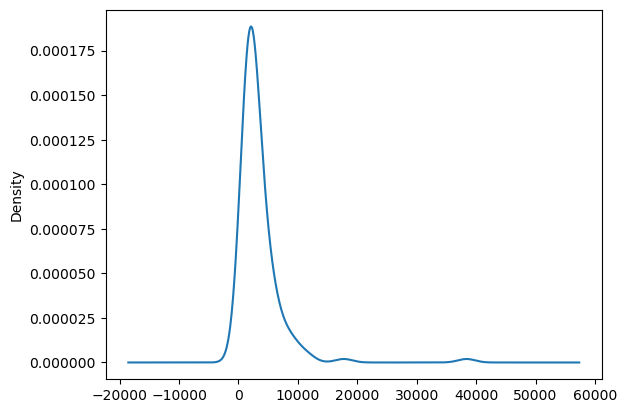

In [8]:
# Visualize the value counts of APPLICATION_TYPE
hood_counts.plot.density()

In [12]:
# Determine which values to replace if counts are less than ...?
replace_hood = list(hood_counts[hood_counts < 1000].index)

# Replace in dataframe
for app in replace_hood:
    crime_df.HOOD_140 = crime_df.HOOD_140.replace(app,"Other")
    
# Check to make sure binning was successful
crime_df.HOOD_140.value_counts()

NSA    38377
77     17730
76     11607
1      11382
75      9857
       ...  
106     1203
8       1184
9       1112
10      1056
57      1042
Name: HOOD_140, Length: 133, dtype: int64

In [15]:
# Generate our categorical variable lists
crime_cat = crime_df.dtypes[crime_df.dtypes == "object"].index.tolist()

crime_cat

['CRIME', 'OCC_DOW', 'PREMISES_TYPE', 'HOOD_140', 'OCC_DATETIME']

In [16]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(crime_df[crime_cat])) 

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(crime_cat)
encode_df.head()

MemoryError: Unable to allocate 122. GiB for an array with shape (480903, 33923) and data type float64

In [ ]:
# Merge one-hot encoded features and drop the originals
crime_df = crime_df.merge(encode_df,left_index=True, right_index=True)
crime_df = crime_df.drop(crime_cat,1)
crime_df.head()

In [ ]:
# Split our preprocessed data into our features and target arrays
#TODO - need column for target
y = crime_df["IS_SUCCESSFUL"].values
X = crime_df.drop(["IS_SUCCESSFUL"],1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [ ]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
# Verify X_Train
X_train_scaled

#### Build single model

In [ ]:
# # Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.

# nn_model = tf.keras.models.Sequential()

# number_input_features = len(X_train[0])
# hidden_nodes_layer1 = 1800
# hidden_nodes_layer2 = 1200

# # First hidden layer
# nn_model.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, activation="relu", input_dim=number_input_features))

# # Second hidden layer
# #nn_model.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# # Output layer
# nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# # Check the structure of the model
# nn_model.summary()

In [ ]:
## OPTIMIZE
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid'])
    
    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=5,
        max_value=90,
        step=5), activation=activation, input_dim=len(X_train[0])))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 6)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=10,
            step=2),
            activation=activation))
    
    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn_model

In [ ]:
## OPTIMIZE 
Import the kerastuner library
import keras_tuner as kt

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=100,
    hyperband_iterations=2)

In [ ]:
## OPTIMIZE 
# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled,y_train,epochs=
             ,validation_data=(X_test_scaled,y_test))

In [ ]:
## OPTIMIZE 
# Get best model hyperparameters
best_hyper = tuner.get_best_hyperparameters(1)[0]
best_hyper.values

In [ ]:
# Compile the model
nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Train the model
fit_model = nn_model.fit(X_train_scaled, y_train, epochs=1
                         00)

In [ ]:
# # Evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

In [ ]:
# Save Model  ###   Final name should be:   AlphabetSoupCharity.h5
nn_model.save("Crime_Optimizer_singleLayer.h5")